<a href="https://colab.research.google.com/github/Mathew057/CS-6301-CNNs/blob/master/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries/Config

In [22]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import numpy as np
import tensorflow_datasets as tfds
import math
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Dense

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)


Found GPU at: /device:GPU:0
Sat Apr 11 00:34:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    39W / 250W |   1609MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                

#Hyperparameters

In [0]:
# data
DATA_NUM_CLASSES        = 10
DATA_CHANNELS           = 3
DATA_ROWS               = 32
DATA_COLS               = 32
DATA_CROP_ROWS          = 28
DATA_CROP_COLS          = 28
DATA_MEAN               = np.array([[[125.30691805, 122.95039414, 113.86538318]]]) # CIFAR10
DATA_STD_DEV            = np.array([[[ 62.99321928,  62.08870764,  66.70489964]]]) # CIFAR10

# training
BATCH_SIZE      = 32
SHUFFLE_BUFFER  = 5000

MODEL_NUM_LAYERS=20

TRAINING_BN_MOMENTUM     = 0.99
TRAINING_BN_EPSILON      = 0.001

TRAINING_LR_MAX          = 0.001
TRAINING_LR_INIT_SCALE   = 0.01
TRAINING_LR_INIT_EPOCHS  = 5
TRAINING_LR_FINAL_SCALE  = 0.01
TRAINING_LR_FINAL_EPOCHS = 25

# training (derived)
TRAINING_NUM_EPOCHS = TRAINING_LR_INIT_EPOCHS + TRAINING_LR_FINAL_EPOCHS
TRAINING_LR_INIT    = TRAINING_LR_MAX*TRAINING_LR_INIT_SCALE
TRAINING_LR_FINAL   = TRAINING_LR_MAX*TRAINING_LR_FINAL_SCALE

# saving
SAVE_MODEL_PATH = './save/model/'
!mkdir -p "$SAVE_MODEL_PATH"

#Load Datasets

In [0]:
AUTOTUNE=tf.data.experimental.AUTOTUNE

# pre processing for training data
def pre_processing_train(example):

    # extract image and label from example
    image = example["image"]
    label = example["label"]
  
    # image is cast to float32, normalized, augmented and random cropped
    # label is cast to int32
    image = tf.math.divide(tf.math.subtract(tf.dtypes.cast(image, tf.float32), DATA_MEAN), DATA_STD_DEV)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, size=[DATA_CROP_ROWS, DATA_CROP_COLS, 3])
    label = tf.dtypes.cast(label, tf.int32)
    
    # return image and label
    return image, label

# pre processing for testing data
def pre_processing_test(example):

    # extract image and label from example
    image = example["image"]
    label = example["label"]

    # image is cast to float32, normalized, augmented and center cropped
    # label is cast to int32
    image = tf.math.divide(tf.math.subtract(tf.dtypes.cast(image, tf.float32), DATA_MEAN), DATA_STD_DEV)
    image = tf.image.crop_to_bounding_box(image, (DATA_ROWS - DATA_CROP_ROWS) // 2, (DATA_COLS - DATA_CROP_COLS) // 2, DATA_CROP_ROWS, DATA_CROP_COLS)
    label = tf.dtypes.cast(label, tf.int32)
    
    # return image and label
    return image, label

# download data and split into training and testing datasets
dataset_train = tfds.load("cifar10", split=tfds.Split.TRAIN)

# transform training dataset
dataset_train = dataset_train.map(pre_processing_train, num_parallel_calls=AUTOTUNE)
dataset_train = dataset_train.shuffle(buffer_size=SHUFFLE_BUFFER)
dataset_train = dataset_train.batch(BATCH_SIZE)
dataset_train = dataset_train.prefetch(AUTOTUNE)


dataset_test = tfds.load("cifar10", split=tfds.Split.TEST)

# transform testing dataset
dataset_test = dataset_test.map(pre_processing_test, num_parallel_calls=AUTOTUNE)
dataset_test = dataset_test.batch(BATCH_SIZE)
dataset_test = dataset_test.prefetch(AUTOTUNE)


#Setup Model

In [25]:

# learning rate schedule
def lr_schedule(epoch):

    # staircase
    # lr = TRAINING_LR_MAX*math.pow(TRAINING_LR_SCALE, math.floor(epoch/TRAINING_LR_EPOCHS))

    # linear warmup followed by cosine decay
    if epoch < TRAINING_LR_INIT_EPOCHS:
        lr = (TRAINING_LR_MAX - TRAINING_LR_INIT)*(float(epoch)/TRAINING_LR_INIT_EPOCHS) + TRAINING_LR_INIT
    else:
        lr = (TRAINING_LR_MAX - TRAINING_LR_FINAL)*max(0.0, math.cos(((float(epoch) - TRAINING_LR_INIT_EPOCHS)/(TRAINING_LR_FINAL_EPOCHS - 1.0))*(math.pi/2.0))) + TRAINING_LR_FINAL

    # debug - learning rate display
    # print(epoch)
    # print(lr)

    return lr

def resnet_layer(inputs, num_filters=16, kernel_size=3,
                 strides=1, activation='relu', batch_normalization=True,
                 conv_first=True):
    
    conv = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same')

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


# create and compile model
def create_model(rows, cols, channels, num_classes, lr_initial, depth):
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)
    # encoder - input
    model_input = keras.Input(shape=(rows, cols, channels), name='input_image')
    x           = model_input
    
    x = resnet_layer(inputs=x)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
                
            y = resnet_layer(inputs=x,
                             num_filters=num_filters, strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters, activation=None)
            
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters, kernel_size=1, strides=strides,
                                 activation=None, batch_normalization=False)
                
                
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # encoder - output
    encoder_output = x

    # decoder
    y              = GlobalAveragePooling2D()(encoder_output)
    decoder_output = Dense(num_classes, activation='softmax')(y)

    # forward path
    model = keras.Model(inputs=model_input, outputs=decoder_output, name='resnetv2_model')

    # loss, backward path (implicit) and weight update
    model.compile(optimizer=tf.keras.optimizers.Adam(lr_initial), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # return model
    return model

# create and compile model
model = create_model(DATA_CROP_ROWS, DATA_CROP_COLS, DATA_CHANNELS, DATA_NUM_CLASSES, TRAINING_LR_MAX, MODEL_NUM_LAYERS)

# model description and figure
model.summary()
# keras.utils.plot_model(model, 'cifar_model.png', show_shapes=True)

Model: "resnetv2_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_127 (Conv2D)             (None, 28, 28, 16)   448         input_image[0][0]                
__________________________________________________________________________________________________
batch_normalization_116 (BatchN (None, 28, 28, 16)   64          conv2d_127[0][0]                 
__________________________________________________________________________________________________
activation_76 (Activation)      (None, 28, 28, 16)   0           batch_normalization_116[0][0]    
_____________________________________________________________________________________

#Train

In [21]:

# callbacks (learning rate schedule, model checkpointing during training)
callbacks = [keras.callbacks.LearningRateScheduler(lr_schedule),
             keras.callbacks.ModelCheckpoint(filepath=SAVE_MODEL_PATH+'model_{epoch}.h5', save_best_only=True, monitor='val_loss', verbose=1)]
             
# training
initial_epoch_num = 0
history           = model.fit(x=dataset_train, epochs=TRAINING_NUM_EPOCHS, verbose=1, callbacks=callbacks, validation_data=dataset_test, initial_epoch=initial_epoch_num)

# example of restarting training after a crash from the last saved checkpoint
# model.load_weights(SAVE_MODEL_PATH+'model_X.h5') # replace X with the last saved checkpoint number
# initial_epoch_num = X                            # replace X with the last saved checkpoint number
# history           = model.fit(x=dataset_train, epochs=TRAINING_NUM_EPOCHS, verbose=1, callbacks=callbacks, validation_data=dataset_test, initial_epoch=initial_epoch_num)



Epoch 1/60
1561/1563 [============================>.] - ETA: 0s - loss: 1.7690 - accuracy: 0.3419
Epoch 00001: val_loss improved from inf to 1.65303, saving model to ./save/model/model_1.h5
1563/1563 [==============================] - 31s 20ms/step - loss: 1.7688 - accuracy: 0.3420 - val_loss: 1.6530 - val_accuracy: 0.3848 - lr: 1.0000e-05
Epoch 2/60
1560/1563 [============================>.] - ETA: 0s - loss: 1.4067 - accuracy: 0.4865
Epoch 00002: val_loss improved from 1.65303 to 1.30374, saving model to ./save/model/model_2.h5
1563/1563 [==============================] - 32s 20ms/step - loss: 1.4062 - accuracy: 0.4867 - val_loss: 1.3037 - val_accuracy: 0.5338 - lr: 2.0800e-04
Epoch 3/60
1563/1563 [==============================] - ETA: 0s - loss: 1.1216 - accuracy: 0.6036
Epoch 00003: val_loss improved from 1.30374 to 1.22871, saving model to ./save/model/model_3.h5
1563/1563 [==============================] - 31s 20ms/step - loss: 1.1216 - accuracy: 0.6036 - val_loss: 1.2287 - val_

#Plots

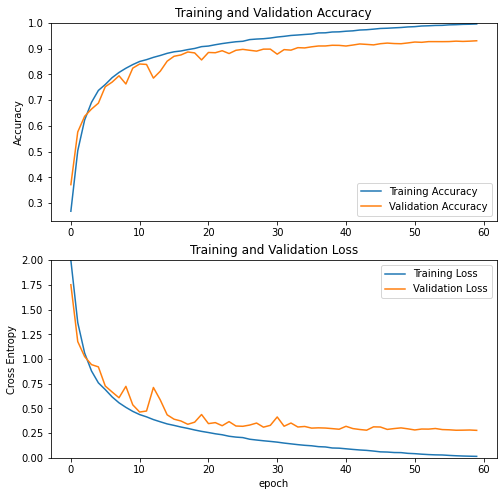

In [8]:
# training and validation data accuracy
acc     = history.history['accuracy']
val_acc = history.history['val_accuracy']

# training and validation data loss
loss     = history.history['loss']
val_loss = history.history['val_loss']

# plot accuracy
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

plt.plot([lr_schedule(epoch) for epoch in range(TRAINING_NUM_EPOCHS)])
plt.ylabel('Learning Rate')
plt.xlabel('epoch')
plt.title("Learning Rate/Epoch")
plt.show()

#Size Comparison

In [27]:
# callbacks (learning rate schedule, model checkpointing during training)
callbacks = [keras.callbacks.LearningRateScheduler(lr_schedule)]

model = create_model(DATA_CROP_ROWS, DATA_CROP_COLS, DATA_CHANNELS, DATA_NUM_CLASSES, TRAINING_LR_MAX, 20)
history_20           = model.fit(x=dataset_train, epochs=TRAINING_NUM_EPOCHS, verbose=1, callbacks=callbacks, validation_data=dataset_test, initial_epoch=initial_epoch_num)


model = create_model(DATA_CROP_ROWS, DATA_CROP_COLS, DATA_CHANNELS, DATA_NUM_CLASSES, TRAINING_LR_MAX, 56)
history_56           = model.fit(x=dataset_train, epochs=TRAINING_NUM_EPOCHS, verbose=1, callbacks=callbacks, validation_data=dataset_test, initial_epoch=initial_epoch_num)


Epoch 1/30
1563/1563 [==============================] - 30s 19ms/step - loss: 2.3352 - accuracy: 0.2181 - val_loss: 1.8859 - val_accuracy: 0.3048 - lr: 1.0000e-05
Epoch 2/30
1563/1563 [==============================] - 30s 19ms/step - loss: 1.4692 - accuracy: 0.4661 - val_loss: 1.2189 - val_accuracy: 0.5578 - lr: 2.0800e-04
Epoch 3/30
1563/1563 [==============================] - 30s 19ms/step - loss: 1.1502 - accuracy: 0.5890 - val_loss: 1.1096 - val_accuracy: 0.6115 - lr: 4.0600e-04
Epoch 4/30
1563/1563 [==============================] - 30s 19ms/step - loss: 0.9892 - accuracy: 0.6530 - val_loss: 1.1587 - val_accuracy: 0.6014 - lr: 6.0400e-04
Epoch 5/30
1563/1563 [==============================] - 30s 19ms/step - loss: 0.8654 - accuracy: 0.6968 - val_loss: 1.2035 - val_accuracy: 0.6073 - lr: 8.0200e-04
Epoch 6/30
1563/1563 [==============================] - 30s 19ms/step - loss: 0.7797 - accuracy: 0.7267 - val_loss: 1.2023 - val_accuracy: 0.6256 - lr: 0.0010
Epoch 7/30
1563/1563 [====

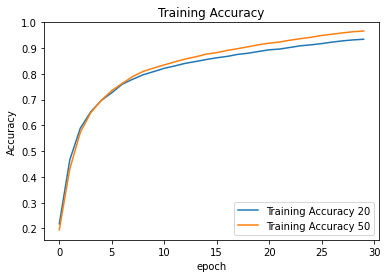

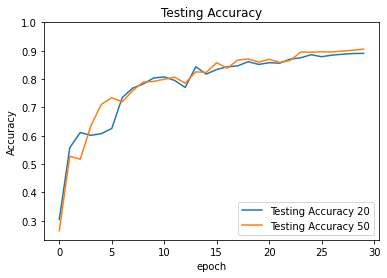

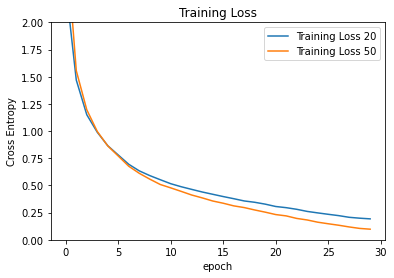

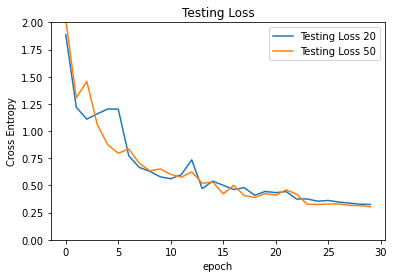

In [28]:
# training and validation data accuracy
acc_20     = history_20.history['accuracy']
loss_20     = history_20.history['loss']

val_loss_20 = history_20.history['val_loss']
val_acc_20 = history_20.history['val_accuracy']

acc_56     = history_56.history['accuracy']
loss_56     = history_56.history['loss']

val_loss_56 = history_56.history['val_loss']
val_acc_56 = history_56.history['val_accuracy']


# plot accuracy
plt.plot(acc_20, label='Training Accuracy 20')
plt.plot(acc_56, label='Training Accuracy 50')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training Accuracy')
plt.show()

# plot accuracy
plt.plot(val_acc_20, label='Testing Accuracy 20')
plt.plot(val_acc_56, label='Testing Accuracy 50')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.ylim([min(plt.ylim()), 1])
plt.title('Testing Accuracy')
plt.show()

plt.plot(loss_20, label='Training Loss 20')
plt.plot(loss_56, label='Training Loss 50')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 2.0])
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

plt.plot(val_loss_20, label='Testing Loss 20')
plt.plot(val_loss_56, label='Testing Loss 50')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 2.0])
plt.title('Testing Loss')
plt.xlabel('epoch')
plt.show()